##Setup

In [0]:
%%capture
!pip install umap-learn
!pip install nltk

In [0]:
from typing import Dict, Any, Callable, List, Tuple, Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import (
   CountVectorizer, TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import FeatureUnion, Pipeline
import numpy as np
import umap.umap_ as umap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.sparse import csr_matrix
from sklearn import metrics

sns.set()

from sklearn.utils.multiclass import unique_labels

In [0]:
filePath = 'dbfs:/FileStore/tables/train.csv'
df = spark.read.csv(filePath, header = True)

In [0]:
df.show()

+------------+-------------+-----------+--------------------+-----------+--------------------+-----------+----+
|     conv_id|utterance_idx|    context|              prompt|speaker_idx|           utterance|   selfeval|tags|
+------------+-------------+-----------+--------------------+-----------+--------------------+-----------+----+
|hit:0_conv:1|            1|sentimental|I remember going ...|          1|I remember going ...|5|5|5_2|2|5|null|
|hit:0_conv:1|            2|sentimental|I remember going ...|          0|Was this a friend...|5|5|5_2|2|5|null|
|hit:0_conv:1|            3|sentimental|I remember going ...|          1|This was a best f...|5|5|5_2|2|5|null|
|hit:0_conv:1|            4|sentimental|I remember going ...|          0| Where has she gone?|5|5|5_2|2|5|null|
|hit:0_conv:1|            5|sentimental|I remember going ...|          1|  We no longer talk.|5|5|5_2|2|5|null|
|hit:0_conv:1|            6|sentimental|I remember going ...|          0|Oh was this somet...|5|5|5_2|2|

##Data analysis
Note that: 
- 'utterance_idx' is the index of an utterance in a conversation
- "prompt" is the prompt with which the Speaker wrote the first sentence (i.e. it's what the conversation should be about)
- 'selfeval' and 'tags' are not used since they are irrelevant
- need to convert '\_commaa_' to ',' for text analysis

In [0]:
df.dtypes

Out[112]: [('conv_id', 'string'),
 ('utterance_idx', 'string'),
 ('context', 'string'),
 ('prompt', 'string'),
 ('speaker_idx', 'string'),
 ('utterance', 'string'),
 ('selfeval', 'string'),
 ('tags', 'string')]

In [0]:
print((df.count(), len(df.columns)))

(84169, 8)


### Context


"context" is the sentiment of the conversation overall \
Source for labels: 
- originate from 8 emotion axes from Plutchik (anger, anticipation, joy, trust, fear, surprise, sadness, disgust)
- add 2 of those are not in Ekman's 6: anticipation and trust"
- divide the above 2 into several adjectives: (anticipating, anxious, prepared) and (trusting, faithful, confident, sentimental, caring), etc.

In [0]:
print("No. contexts:", len(df.select('context').distinct().collect()), "in", df.count(), "data")

No. contexts: 32 in 84169 data


In [0]:
print("All contexts:") 
df.select('context').distinct().show(40)

All contexts:
+------------+
|     context|
+------------+
| embarrassed|
|     furious|
|    grateful|
|   surprised|
|      afraid|
|disappointed|
|  devastated|
|   terrified|
|    faithful|
|       angry|
|     content|
|         sad|
|     hopeful|
|   impressed|
|    prepared|
|     excited|
|     ashamed|
|       proud|
|   confident|
|   nostalgic|
|     anxious|
|   disgusted|
| sentimental|
|anticipating|
|      joyful|
|      caring|
|     annoyed|
|      guilty|
|    trusting|
|     jealous|
|apprehensive|
|      lonely|
+------------+



#### For each Context

In [0]:
print("No. responses for each context:")
df.groupBy('context').count().orderBy('count').show(40)

No. responses for each context:
+------------+-----+
|     context|count|
+------------+-----+
|    faithful| 1660|
|apprehensive| 2014|
|     ashamed| 2191|
|    trusting| 2270|
|      caring| 2292|
| sentimental| 2298|
| embarrassed| 2407|
|  devastated| 2425|
|     content| 2479|
|    prepared| 2529|
|     jealous| 2540|
|      joyful| 2555|
|disappointed| 2567|
|   nostalgic| 2595|
|   impressed| 2630|
|anticipating| 2632|
|     hopeful| 2638|
|     anxious| 2651|
|   confident| 2657|
|     furious| 2663|
|   disgusted| 2663|
|      guilty| 2675|
|   terrified| 2708|
|      afraid| 2728|
|    grateful| 2736|
|      lonely| 2751|
|     annoyed| 2880|
|         sad| 2883|
|       proud| 2933|
|       angry| 2991|
|     excited| 3218|
|   surprised| 4310|
+------------+-----+



In [0]:
print("Average number of responses per context:")
df.groupBy('context').count().orderBy('count').select('count').describe().show()

Average number of responses per context:
+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|               32|
|   mean|       2630.28125|
| stddev|424.0589759938674|
|    min|             1660|
|    max|             4310|
+-------+-----------------+



Boxplot for no. responses:


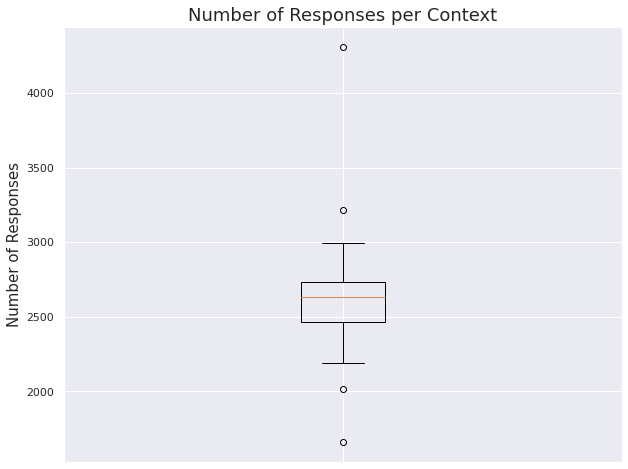

In [0]:
print("Boxplot for no. responses:")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.boxplot(df.groupBy('context').count().select('count').rdd.map(lambda x: x[0]).collect())
ax.set_title("Number of Responses per Context", fontsize=18)
ax.set_ylabel("Number of Responses", fontsize=15)
ax.set_xticklabels("")
plt.show()

Distribution of responses by context:


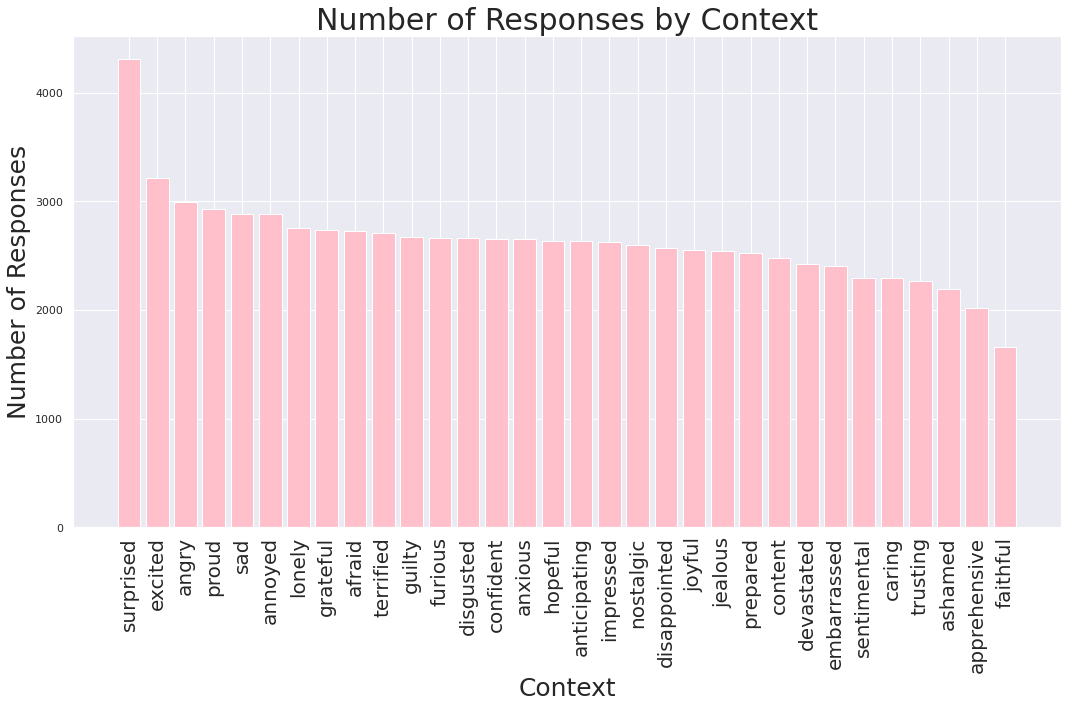

In [0]:
keys = df.groupBy('context').count().orderBy('count',ascending=False).rdd.map(lambda x: x[0]).collect()
values = df.groupBy('context').count().orderBy('count',ascending=False).rdd.map(lambda x: x[1]).collect()
print("Distribution of responses by context:")
fig, ax = plt.subplots(figsize=(15, 10))
#.plot.bar(ax=ax, color="pink")
plt.bar(keys,values, color="pink")
ax.set_title("Number of Responses by Context", fontsize=30)
ax.set_xlabel("Context", fontsize=25)
ax.set_ylabel("Number of Responses", fontsize=25)
plt.xticks(rotation='vertical', fontsize=20)
plt.tight_layout()
#plt.savefig("figures/responses_by_topics_count.png")

### Conversation
A conversation spans 1 or more rows

In [0]:
print("No. conversations:", len(df.select('conv_id').distinct().collect()), "in", df.count(), "data")

No. conversations: 19533 in 84169 data


In [0]:
print("No. respones for each conversation:")
df.groupby("conv_id").count().withColumnRenamed("count", "length").groupby("length").count().orderBy('count',ascending=False).show()

No. respones for each conversation:
+------+-----+
|length|count|
+------+-----+
|     4|15136|
|     5| 3421|
|     6|  463|
|     8|  268|
|     7|  218|
|     3|   20|
|     2|    5|
|     1|    2|
+------+-----+



In [0]:
print("No. respones for each prompt:")
df.groupby("prompt").count().withColumnRenamed("count", "length").groupby("length").count().orderBy('count',ascending=False).show(10)

No. respones for each prompt:
+------+-----+
|length|count|
+------+-----+
|     4|14713|
|     5| 3360|
|     6|  461|
|     8|  349|
|     7|  217|
|    12|   25|
|     3|   19|
|    10|   11|
|    16|   11|
|     9|    9|
+------+-----+
only showing top 10 rows



'conv_id' and 'prompt' are basically 1-to-1 i.e. conversation corresponds to 1 prompt and vice versa

Distribution of number of responses:


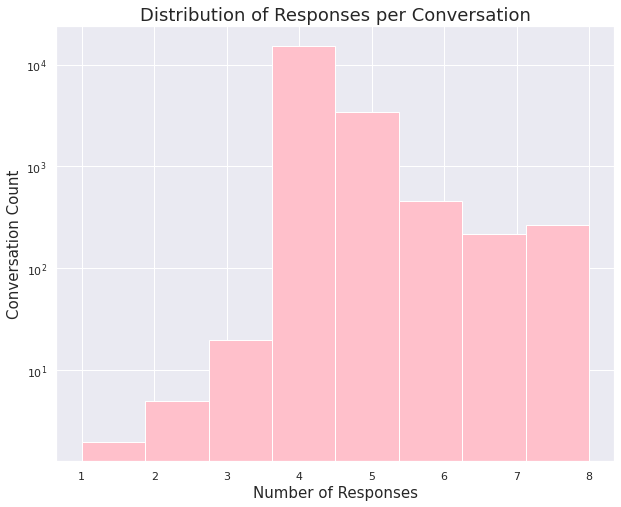

In [0]:
values = df.groupby("conv_id").count().rdd.map(lambda x: x[1]).collect()
print("Distribution of number of responses:")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.hist(values, bins=8, log=True, color="pink")
ax.set_title("Distribution of Responses per Conversation", fontsize=18)
ax.set_ylabel("Conversation Count", fontsize=15)
ax.set_xlabel("Number of Responses", fontsize=15)
plt.show()
#plt.savefig("figures/number_responses.png")

### Speaker

In [0]:
print("No. speakers:", len(df.select('speaker_idx').distinct().collect()), "in", df.count(), "data")

No. speakers: 810 in 84169 data


Distribution of no. contexts engaged by speakers:


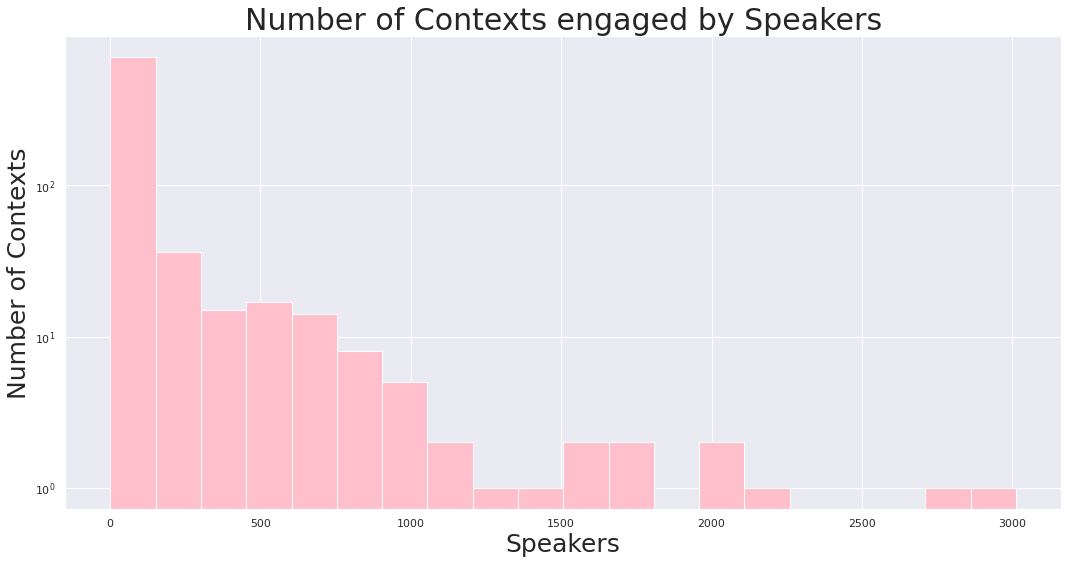

In [0]:
print("Distribution of no. contexts engaged by speakers:")
values = df.select(["speaker_idx","context"]).groupby("speaker_idx").count().rdd.map(lambda x: x[1]).collect()
fig, ax = plt.subplots(figsize=(15, 8))
plt.hist(values, bins=20, log=True, color="pink")
ax.set_title("Number of Contexts engaged by Speakers", fontsize=30)
ax.set_xlabel("Speakers", fontsize=25)
ax.set_ylabel("Number of Contexts", fontsize=25)
plt.tight_layout()
#plt.savefig("figures/responses_by_topics_count.png")

Some speakers actively engage in many contexts

Distribution of no. speakers engaged in a context:


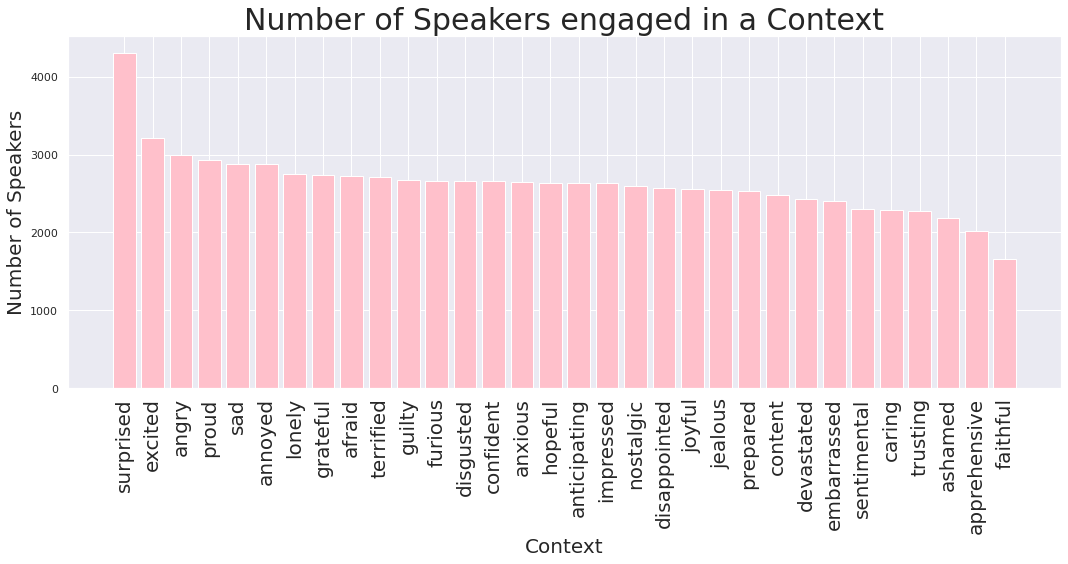

In [0]:
print("Distribution of no. speakers engaged in a context:")
keys = df.select(["speaker_idx","context"]).groupby("context").count().orderBy('count',ascending=False).rdd.map(lambda x: x[0]).collect()
values = df.select(["speaker_idx","context"]).groupby("context").count().orderBy('count',ascending=False).rdd.map(lambda x: x[1]).collect()
fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(keys,values, color="pink")
ax.set_title("Number of Speakers engaged in a Context", fontsize=30)
ax.set_xlabel("Context", fontsize=20)
ax.set_ylabel("Number of Speakers", fontsize=20)
plt.xticks(rotation='vertical', fontsize=20)
plt.tight_layout()
#plt.savefig("figures/responses_by_topics_count.png")

Each context involves a similar amount of speakers

## Text analysis

Convert '\_commaa_' to ',' for text data

In [0]:
df.select('utterance').show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 utterance | I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. 
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 utterance | Was this a friend you were in love with_comma_ or just a best friend?                                                                                                                                    
only showing top 2 rows



In [0]:
texts = []
for text in df.select("utterance").rdd.map(lambda x: x[0]).collect():
    text = text.replace('_comma_',',').lower().strip()
    texts.append(text)

In [0]:
texts[:2]

Out[311]: ['i remember going to see the fireworks with my best friend. it was the first time we ever spent time alone together. although there was a lot of people, we felt like the only people in the world.',
 'was this a friend you were in love with, or just a best friend?']

Distribution of length of responses:


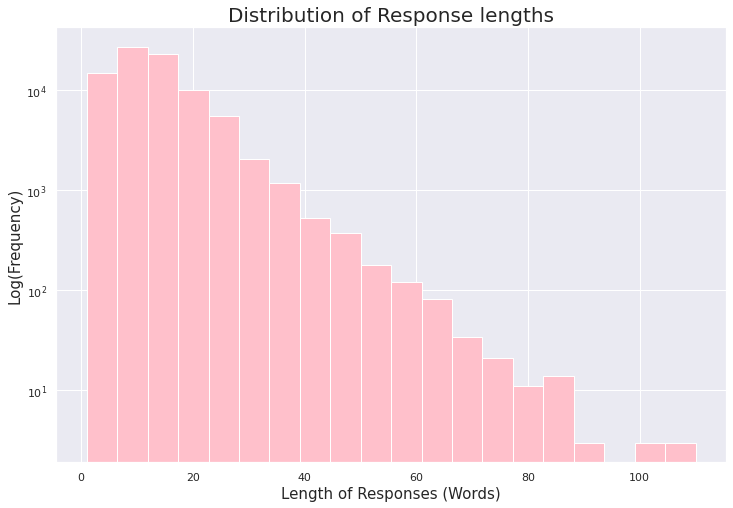

In [0]:
values = [len(text.split(" ")) for text in texts]
print("Distribution of length of responses:")
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.hist(values, bins=20, log=True, color="pink")
ax.set_xlabel("Length of Responses (Words)", fontsize=15)
ax.set_ylabel("Log(Frequency)", fontsize=15)
ax.set_title("Distribution of Response lengths", fontsize=20)
plt.show()

### Simple context prediction
Analyse the relationship between responses ('utterance') and 'context' via a simple context prediction model

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def lower(s):
    """
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    return [ps.stem(token) for token in tokens]

def filter_stopwords(tokens):
    """
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import string
def filter_punctuations(tokens):
    return [token for token in tokens if token not in string.punctuation]

def concat(tokens):
    sentence = ""
    for token in tokens:
        sentence = sentence + str(token) + " "
    return sentence

In [0]:
x = []
for text in texts:
    text = tokenize(text)
    text = stem(text)
    text = filter_stopwords(text)
    text = filter_punctuations(text)
    text = lower(text)
    text = concat(text)
    x.append(text)
y = df.select("context").rdd.map(lambda x: x[0]).collect()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)
print(len(x_train), len(x_val), len(y_train), len(y_val))

67335 16834 67335 16834


In [0]:
x_train[7]

Out[333]: 'thi morn went outsid harvest veget garden discov anim gotten first though '

#### Helper function

In [0]:
def calculate_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    average: Optional[str] = None,
    return_df: bool = True,
) -> Union[Dict[str, float], pd.DataFrame]:
    """Computes f1, precision, recall, kappa, accuracy, and support
    Args:
        y_true: The true labels
        y_pred: The predicted labels
        average: How to average multiclass results
        return_df: Returns a dataframe if true otherwise a dictionary of performance
            values.
    Returns:
        Either a dataframe of the performance metrics or a single dictionary
    """
    labels = unique_labels(y_true, y_pred)

    # get results
    precision, recall, f_score, support = metrics.precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=average
    )

    kappa = metrics.cohen_kappa_score(y_true, y_pred, labels=labels)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    # create a pandas DataFrame
    if return_df:
        results = pd.DataFrame(
            {
                "class": labels,
                "f_score": f_score,
                "precision": precision,
                "recall": recall,
                "support": support,
                "kappa": kappa,
                "accuracy": accuracy,
            }
        )
    else:
        results = {
            "f": f_score,
            "precision": precision,
            "recall": recall,
            "kappa": kappa,
            "accuracy": accuracy,
        }

    return results

In [0]:
def visualize_performance(
        df: pd.DataFrame,
        metrics: List[str],
        ax: Optional[Any] = None,
        title: Optional[str] = None,
        ylim: Optional[Tuple[float, float]] = None,
        figsize: Optional[Tuple[int, int]] = None,
        use_class_names: bool = True
) -> None:
    """Takes a Performance DF and converts it to a bar plot performance graph
    Args:
        df: A dataframe where each row is a class and each column is a metric
        metrics: A list of metrics from the columns of df to plot
        ax: A matplotlib axes object that we want to draw the plot on
        title: The title of the plot
        ylim: The minimum and maximum range for the yaxis.
        figsize: The width and height of the figure.  This does nothing if ax is set
        use_class_names: This will label the x ticks with the class name in a multiclass setting.
    """
    unstacked_df = (
        df[metrics]
            .T.unstack()
            .reset_index()
            .rename(
            index=str, columns={"level_0": "class", "level_1": "metric", 0: "score"}
        )
    )

    if use_class_names:
        unstacked_df["class"] = unstacked_df["class"].apply(
            lambda x: df["class"].tolist()[x]
        )

    if figsize is None:
        figsize = (10, 7)

    # Diplay the graph
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    #sns.color_palette("rocket", as_cmap=True)
    sns.barplot(x="class", y="score", hue="metric", data=unstacked_df, ax=ax, palette=sns.color_palette("Set2"))

    # Format the graph
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if title is not None:
        ax.set_title(title, fontsize=20)

    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()

#### Build and train

In [0]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

svm_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(ngram_range=(1, 3))),
        ("classifier", classifier),
    ]
)

svm_model.fit(x_train, y_train)

Out[336]: Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('classifier', LinearSVC(class_weight='balanced'))])

In [0]:
svm_preds = svm_model.predict(x_train)
sum(svm_preds == y_train)/ len(y_train)

Out[337]: 0.9448132471968516

### Visualize results

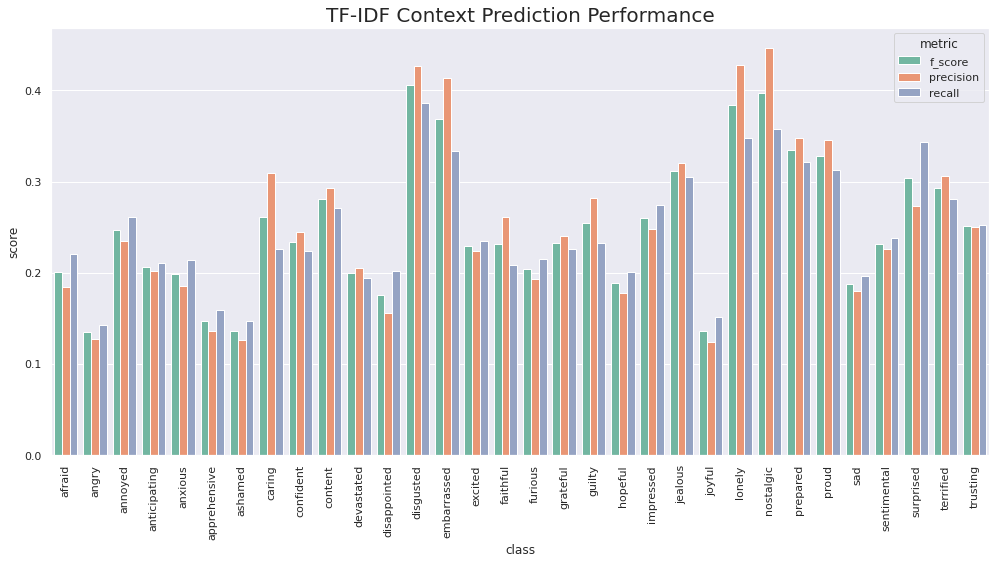

In [0]:
svm_preds = svm_model.predict(x_val)
svm_perf_df = calculate_classification_metrics(svm_preds, y_val)
svm_ax = visualize_performance(svm_perf_df,
                              ["f_score", "precision", "recall"],
                              title="TF-IDF Context Prediction Performance")

In [0]:
# Examine top features
coefs = svm_model.named_steps["classifier"].coef_
if type(coefs) == csr_matrix:
    coefs.toarray().tolist()[0]
else:
    coefs.tolist()
feature_names = svm_model.named_steps["tfidf"].get_feature_names()
coefs_and_features = list(zip(coefs[0], feature_names))
top_features = sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)[:20]
top_features

Out[339]: [(2.0291635486290422, 'dark'),
 (1.5083638667762036, 'cool great'),
 (1.5020476548113761, 'wasp'),
 (1.4912727304605125, 'werewolv'),
 (1.4864206848785508, 'afraid'),
 (1.4644509302281472, 'frighten'),
 (1.4384247894434987, 'scari'),
 (1.4062788694093162, 'glad alright'),
 (1.3974131179255012, 'wa bet'),
 (1.3893297970910714, 'nice happi'),
 (1.3426446538041872, 'long account'),
 (1.338536281757661, 'insan stuff'),
 (1.3371577175722305, 'yike today'),
 (1.3343867206458933, 'sorri grow'),
 (1.3339188319478628, 'horror'),
 (1.3310171541057207, 'suck ok'),
 (1.3265465169809463, 'know nervou'),
 (1.3259118684388354, 'point haha'),
 (1.3258473677988216, 'play trick'),
 (1.320477320023335, 'protect')]

Out[340]: Text(0.5, 0, 'Feature Name')

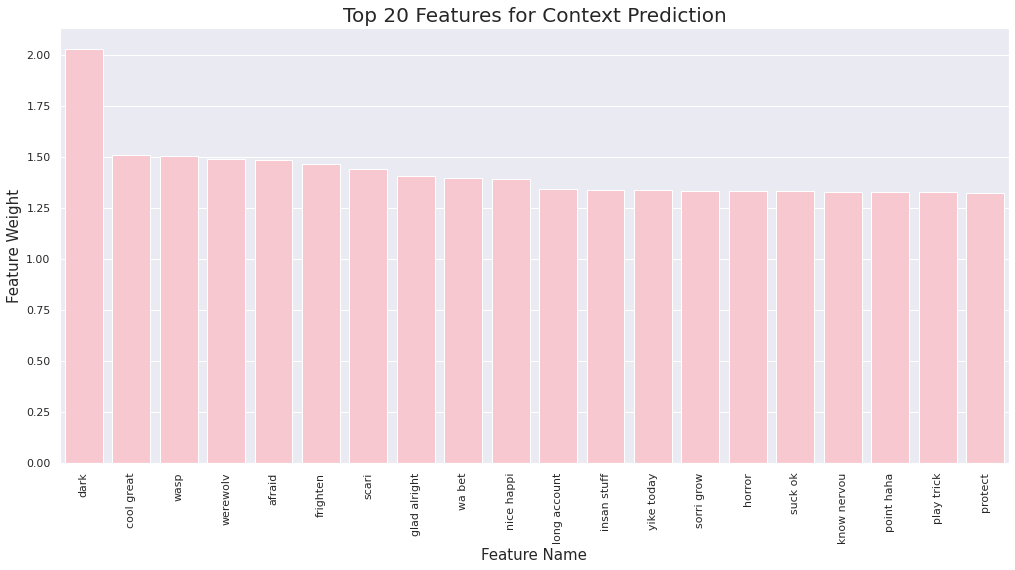

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))
sns.barplot(x="features", y="value", data=pd.DataFrame(top_features, columns=["value", 'features']), ax=ax, color="pink")
ax.set_xticklabels([x[1] for x in top_features], rotation=90)
ax.set_title("Top 20 Features for Context Prediction", fontsize=20)
ax.set_ylabel("Feature Weight", fontsize=15)
ax.set_xlabel("Feature Name", fontsize=15)